  # TPSA Classification Training on baseline embedding 

# Setup

In [1]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import random
from typing import List, Tuple
from types import SimpleNamespace
import pprint
import logging
from datetime import datetime
for p in ['./src','../pt-snnl','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

import scipy
import scipy.stats as sps
import sklearn.metrics as skm
from scipy.spatial.distance import pdist, squareform, euclidean

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=180, profile=None, sci_mode=None)
torch.manual_seed(42);   # seed rng for reproducibility
pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2"

torch.set_num_threads(4)  ## <--- limit to ~ 2 CPUs
torch.get_num_threads()

insert ./src
insert ../pt-snnl
insert ../..
['../..', '../pt-snnl', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


4

In [3]:
# from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle, get_device
import KevinsRoutines.utils as myutils
# import snnl.utils as utils
# from utils.utils_ptsnnl import display_cellpainting_batch, get_device
from utils.utils_cellpainting import label_counts, balance_datasets,save_checkpoint, load_checkpoint 
from utils.dataloader import custom_collate_fn,CellpaintingDataset, InfiniteDataLoader
from utils.utils_notebooks import plot_cls_metrics, compute_classification_metrics, run_model_on_test_data,\
                                train, validation, accuracy_fn, fit, build_model, define_datasets

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [4]:
# Set visible GPU device 
# ----------------------------------------------
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
myutils.set_device(2);
device = myutils.get_device(verbose = True);
print(device)

 Switched to: "cuda:2"   Device Name: NVIDIA TITAN Xp               


'cuda:2'

Dev Id   Device Name                    Total Memory                     InUse                            Free Memory 
   0     Quadro GV100                   34,069,872,640 B/ (31.73 GB)  	 645,922,816 B / (0.60 GB)  	 33,423,949,824 B / (31.13 GB)  
   1     Quadro GV100                   34,069,872,640 B/ (31.73 GB)  	 645,922,816 B / (0.60 GB)  	 33,423,949,824 B / (31.13 GB)  
   2     NVIDIA TITAN Xp                12,774,539,264 B/ (11.90 GB)  	 392,298,496 B / (0.37 GB)  	 12,382,240,768 B / (11.53 GB)   *** CURRENT DEVICE *** 

 Current CUDA Device is:  "cuda:2"  Device Name: NVIDIA TITAN Xp
cuda:2


In [5]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)
logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version   : {pd.__version__}  ")

2024-10-17 13:46:44,688 - __main__ - INFO: -  Excution started : 2024_10_17_13:46:44 
2024-10-17 13:46:44,689 - __main__ - INFO: -  Pytorch version  : 2.2.0
2024-10-17 13:46:44,690 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-10-17 13:46:44,691 - __main__ - INFO: -  Pandas version   : 2.2.0  


# Args 

In [6]:
SEED                = 9999
LATENT_DIM          = 250
COMPOUNDS_PER_BATCH = 600
TPSA_THRESHOLD      = 100
myutils.set_global_seed(SEED)

# MODEL_TYPE = 'batch_norm'
MODEL_TYPE = 'single_layer'
# MODEL_TYPE = 'relu'

n_input    = LATENT_DIM  # the embedding dimensionality 
n_hidden_1 = 256  # the number of neurons in the hidden layer of the MLP
n_hidden_2 = 256  # the number of neurons in the hidden layer of the MLP
n_hidden_3 = 128

METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA', 'Metadata_Permiation']
# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
input_cols = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(input_cols)

# OUTPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
CKPT_PATH = "./saved_models/embedding_models"

# SNNL AUTOENCODERS 
# AE_RUNMODE = "snnl"
# AE_DATETIME = "20240718_1956"
# AE_DATETIME = "20240906_2201"     # Autoencoder training - SNNL, CPB = 600, Latent 150, WD = 0.001, SNN Factor 3
# AE_DATETIME = "20240917_2004"     # Autoencoder training - SNNL, CPB = 600, Latent 250, WD = 0.001, SNN Factor 3

## BASELINE AUTOENCODERS 
AE_RUNMODE = 'base'
# AE_DATETIME = "20240923_1943"     # Autoencoder training - Baseline, CPB = 600, Latent 150, WD = 0.001 (SNN Factor 0)
AE_DATETIME = "20240917_2017"     # Autoencoder training - Baseline, CPB = 600, Latent 250, WD = 0.001 (SNN Factor 0)

# AE_CKPTTYPE = "BEST"
AE_CKPTTYPE = "LAST"

 Seed value set to 9999 in random, np.random, and torch
11
261


In [7]:
# RUN_DATETIME = datetime.now().strftime('%Y%m%d_%H%M')

# RUN_DATETIME = '20241002_1915'   ## Baseline CPB 600, Latent 150  - Single layer 256
# RUN_DATETIME = '20241002_1916'   ## Baseline CPB 600, Latent 150  - Single layer 256
# RUN_DATETIME = '20241002_1917'   ## Baseline CPB 600, Latent 150  - Single layer 256
# RUN_DATETIME = '20241002_1918'   ## Baseline CPB 600, Latent 150  - Single layer 256
 
# RUN_DATETIME = '20240926_1900'   ## Baseline CPB 600, Latent 250  - Single layer 256
# RUN_DATETIME = '20240926_1901'   ## Baseline CPB 600, Latent 250  - Single layer 256
# RUN_DATETIME = '20240926_1902'   ## Baseline CPB 600, Latent 250  - Single layer 256
RUN_DATETIME = '20240926_1903'   ## Baseline CPB 600, Latent 250  - Single layer 256

# RUN_DATETIME = '20240927_2300'   ## Baseline CPB 600, Latent 250  - Single layer 512
# RUN_DATETIME =                   ## Baseline CPB 600, Latent 250  - Balanced TPSA Labels - ReLU 256/256/128
# RUN_DATETIME = '20240929_2000'   ## Baseline CPB 600, Latent 250  - Batch Norm 256/256/128
# RUN_DATETIME = '20240929_1900'   ## Baseline CPB 600, Latent 250  - Batch Norm 512/512/128

# RUN_DATETIME = '20240910_2315'   ## Baseline CPB 600, Latent 250  - Balanced TPSA Labels - Single layer 256
# RUN_DATETIME = '20241003_2330'   ## Baseline CPB 600, Latent 250  - Balanced TPSA Labels - Single layer 512
# RUN_DATETIME =                   ## Baseline CPB 600, Latent 250  - Balanced TPSA Labels - ReLU 256/256/128
# RUN_DATETIME = '20240930_2100'   ## Baseline CPB 600, Latent 250  - Balanced TPSA labels - Batch Norm 256/256/128
# RUN_DATETIME = '20241001_2100'   ## Baseline CPB 600, Latent 250  - Balanced TPSA labels - Batch Norm 512/512/256
print(RUN_DATETIME)

20240926_1903


In [8]:
CKPT_FILE = f"NN_{AE_RUNMODE.lower()}_embd600_{LATENT_DIM}Ltnt_512_{AE_DATETIME}_{AE_CKPTTYPE}_{RUN_DATETIME}_ep_{{ep}}"
print(CKPT_FILE)

NN_base_embd600_250Ltnt_512_20240917_2017_LAST_20240926_1903_ep_{ep}


In [9]:
## total rows = 346,542
## Trn file sz: 312,000 
## Train      : 277,200    (312_000 - (21,600 + 12,600 + 600) = 277,200
## Validation :  21,600
## Test       :  12,600
## Leftover   :     600
cellpainting_args = {'compounds_per_batch': COMPOUNDS_PER_BATCH,
                     'train_start'        : 0,
                     'train_end'          : 277_200,
                     'val_start'          : 0,
                     'val_end'            : 21_600,
                     'test_start'         : 0,
                     'test_end'           : 12_600, 
                    }

In [10]:
data_loader = define_datasets(cellpainting_args, AE_RUNMODE, AE_DATETIME, input_cols, AE_CKPTTYPE, INPUT_PATH, tpsa_threshold=TPSA_THRESHOLD)

2024-10-17 13:47:08,829 - utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-10-17 13:47:08,830 - utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_base_20240917_2017_LAST_train.csv
2024-10-17 13:47:08,831 - utils.dataloader - INFO: -  type    :  train
2024-10-17 13:47:08,831 - utils.dataloader - INFO: -  start   :  0
2024-10-17 13:47:08,832 - utils.dataloader - INFO: -  end     :  277200
2024-10-17 13:47:08,833 - utils.dataloader - INFO: -  numrows :  277200
2024-10-17 13:47:08,833 - utils.dataloader - INFO: -  names   :  None     usecols :  None
2024-10-17 13:47:08,834 - utils.dataloader - INFO: -  batch_size  :  1
2024-10-17 13:47:08,835 - utils.dataloader - INFO: -  sample_size :  3
2024-10-17 13:47:08,835 - utils.dataloader - INFO: -  compounds_per_batch :  600
2024-10-17 13:47:08,836 - utils.dataloader - INFO: -  rows per batch (chunksize) :  1800
2024-1

 TRAIN_INPUT:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_base_20240917_2017_LAST_train.csv
 TEST_INPUT :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_base_20240917_2017_LAST_train_sub_test.csv
 ALL_INPUT  :  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_base_20240917_2017_LAST_train_sub_val.csv
 load {}
 Dataset size: 277200   rows per batch: 1800  tpsa_threshold: 100
 Dataset size: 21600   rows per batch: 1800  tpsa_threshold: 100
 Dataset size: 12600   rows per batch: 1800  tpsa_threshold: 100


### Input Dataloader

In [48]:
# TRAIN_INPUT_FILE = f"3smpl_prfl_embedding_{num_cols}_HashOrder_{ae_runmode}_{ae_datetime}_{ae_ckpttype}_train.csv"
# TEST_INPUT_FILE  = f"3smpl_prfl_embedding_{num_cols}_HashOrder_{ae_runmode}_{ae_datetime}_{ae_ckpttype}_train_sub_test.csv"
# VAL_INPUT_FILE   = f"3smpl_prfl_embedding_{num_cols}_HashOrder_{ae_runmode}_{ae_datetime}_{ae_ckpttype}_train_sub_val.csv"
# # ALL_INPUT_FILE   = f"3smpl_prfl_embedding_{num_cols}_HashOrder_{ae_runmode}_{ae_datetime}_{ae_ckpttype}_sub_val.csv"

# print(TRAIN_INPUT_FILE)
# print(TEST_INPUT_FILE)
# print(VAL_INPUT_FILE)

# TRAIN_INPUT = os.path.join(INPUT_PATH, TRAIN_INPUT_FILE)
# TEST_INPUT  = os.path.join(INPUT_PATH, TEST_INPUT_FILE)
# VAL_INPUT   = os.path.join(INPUT_PATH, VAL_INPUT_FILE)

# print(f" TRAIN_INPUT:  {TRAIN_INPUT}")
# print(f" TEST_INPUT :  {TEST_INPUT }")
# print(f" ALL_INPUT  :  {VAL_INPUT }")

In [49]:
## total rows = 346,542
## Trn file sz: 312,000 
## Train      : 277,200    (312_000 - (21,600 + 12,600 + 600) = 277,200
## Validation :  21,600
## Test       :  12,600
## Leftover   :     600
# cellpainting_args = {'sample_size': 3,
#                      'batch_size': 1,
#                      'compounds_per_batch': 600,
#                      'training_path'  : TRAIN_INPUT,
#                      'validation_path': TRAIN_INPUT,
#                      'test_path'      : TRAIN_INPUT,
#                      'train_start'    : 0,
#                      'train_end'      : 277_200,  # 277,200 samples
#                      'val_start'      : 277_200,  # 
#                      'val_end'        : 298_800,  # 21_600 samples
#                      'test_start'     : 298_800,  # 
#                      'test_end'       : 311_400,  # 12_600 samples
#                     }

# cellpainting_args = {'compounds_per_batch': COMPOUNDS_PER_BATCH,
#                      'training_path'      : TRAIN_INPUT,
#                      'validation_path'    :  VAL_INPUT,
#                      'test_path'          : TEST_INPUT,
#                      'train_start'        : 0,
#                      'train_end'          : 277_200,
#                      'val_start'          : 0,
#                      'val_end'            : 21_600,
#                      'test_start'         : 0,
#                      'test_end'           : 12_600,
#                      'tpsa_threshold'     : 100
#                     }

In [50]:
# cellpainting_args

In [51]:
#### Load CellPainting Dataset
# data : keys to the dataset settings (and resulting keys in output dictionary)
# dataset = dict()
# data_loader = dict()

# print(f" load {dataset}")
# for datatype in ['train', 'val', 'test']:
#     dataset[datatype] = CellpaintingDataset(type = datatype, **cellpainting_args)
#     data_loader[datatype] = InfiniteDataLoader(dataset = dataset[datatype], batch_size=1, shuffle = False, num_workers = 0, collate_fn = custom_collate_fn)

In [52]:
# %%timeit
# for dataset in ['train', 'val', 'test']:
#     for idx, batch in enumerate(data_loader[dataset]):
#         print(batch[0].shape[0], batch[1].sum())
#         # display_cellpainting_batch(idx, batch)
#         if idx == 1:
#             break

In [53]:
# # -----------------------------------------
# #  Count pos/neg labels in each dataset
# # -----------------------------------------
# for datatype in ['train', 'val', 'test']:
#     MINIBATCH_SIZE = data_loader[datatype].dataset.sample_size * data_loader[datatype].dataset.compounds_per_batch
#     print(f" {datatype.capitalize()} Minibatch size : {MINIBATCH_SIZE} \n") 
#     minibatches = len(data_loader[datatype]) // MINIBATCH_SIZE
#     ttl_rows = 0
#     ttl_pos_labels = 0
#     with tqdm.tqdm(enumerate(data_loader[datatype]), initial=0, total = minibatches, position=0, file=sys.stdout,
#                    leave= False, desc=f" Count labels ") as t_warmup:
#         for batch_count, (batch_features, batch_labels, _, _, _, _, _) in t_warmup:
#             ttl_rows += batch_labels.shape[0]
#             ttl_pos_labels += batch_labels.sum()
#     ttl_neg_labels = ttl_rows - ttl_pos_labels
#     ttl = f"\n Dataset: {datatype} -  len of {datatype} data loader: {len(data_loader[datatype])}   number of batches: {minibatches}"
#     print(ttl)
#     print('-'*len(ttl))
#     print(f" total rows     : {ttl_rows:7d}")
#     print(f" total pos rows : {ttl_pos_labels:7.0f} - {ttl_pos_labels*100.0/ttl_rows:5.2f}%")
#     print(f" total neg rows : {ttl_neg_labels:7.0f} - {ttl_neg_labels*100.0/ttl_rows:5.2f}%")
#     print()

     Minibatch size : 1800 
                                                                                                 
     Dataset: train - len of train data loader: 277200   number of batches: 154  
    ------------------------------
     total rows     :  277200
     total pos rows :   33129 - 11.95%
     total neg rows :  244071 - 88.05%

     Dataset: val - len of val data loader: 21600   number of batches: 12
    ------------------------------
     total rows     :   21600
     total pos rows :    2532 - 11.72%
     total neg rows :   19068 - 88.28%
    
     Dataset: test - len of test data loader: 12600   number of batches: 7
    ------------------------------
     total rows     :   12600
     total pos rows :    1431 - 11.36%
     total neg rows :   11169 - 88.64%

# Define Neural Net Model 

 - **Single Hidden Layer - 256**
    -  **202419002_1915** : Read from 20240923_1943 (Baseline - CPB 600, LAT 150)
    -  **202419002_1916** :  "      "
    -  **202419002_1917** :  "      "
    -  **202419002_1918** :  "      "


 - **Single Hidden Layer - 256 - Balanced dataset**

    - **20240926_1900** : Read from 20240917_2017 (BASELINE - CPB 600, LAT 250, SNN Factor 0) - balanced dataset

 - **Single Hidden Layer - 512**

    -  **20240921_0700** : Run on 1 FC layers model (includes final layer), Input --> 512 --> Tanh --> 1 ,  Read from 20240906_2201 (SNNL - CPB 600, LAT 150, SNN Factor 3)    


In [11]:

model = build_model(MODEL_TYPE, input = n_input, hidden_1 = n_hidden_1, hidden_2 = n_hidden_2, hidden_3=n_hidden_3, device = device)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Mult-Adds                 Trainable
Sequential                               [30, 250]                 [30, 1]                   --                             --                   --                        True
├─Linear: 1-1                            [30, 250]                 [30, 256]                 64,256                     99.60%                   1,927,680                 True
│    └─weight                                                                                ├─64,000
│    └─bias                                                                                  └─256
├─Tanh: 1-2                              [30, 256]                 [30, 256]                 --                             --                   --                        --
├─Linear: 1-3                            [30, 256]                 [30, 1]                  

In [12]:
metrics = { 'loss_trn' : [], 'acc_trn' : [], 'loss_val' : [], 'acc_val' : []}

start_epoch, end_epoch = 0,0
init_LR = 1.0e-3
# curr_LR = init_LR

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=init_LR)

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.3 , patience=20, cooldown=10,)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = step_size, gamma=0.1, last_epoch =-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, threshold=1.0e-06, patience=50, cooldown=10,)

### Read checkpoint

In [13]:
# loaded_epoch
# optimizer.state_dict()
# scheduler.state_dict()

In [14]:
# model, optimizer, scheudler, end_epoch = load_checkpoint(model, optimizer, scheduler, checkpoint_file.format(ep=100), ckpt_path = CKPT_PATH)
# model = model.to(device)

In [15]:
# end_epoch
# optimizer.state_dict()
# scheduler.state_dict()

# Run Training

In [16]:
start_epoch, end_epoch = 0,400
# start_epoch = 0
# start_epoch = loaded_epoch
# start_epoch = end_epoch
# end_epoch += 600
print(start_epoch, end_epoch)
_ = model.train()

0 400


In [ ]:

metrics = fit(model, optimizer, scheduler, data_loader, metrics, start_epoch, end_epoch, device, CKPT_FILE, CKPT_PATH )


 13:47:41 | Ep:   1/ 400 | Trn loss:  0.370747 - Acc: 87.7042 | Val loss:  0.356370 - Acc: 88.2778 | last_lr: 1.00000e-03  bad_ep: 0  cdwn: 0                              
 13:48:03 | Ep:   2/ 400 | Trn loss:  0.360655 - Acc: 88.0599 | Val loss:  0.355653 - Acc: 88.2778 | last_lr: 1.00000e-03  bad_ep: 0  cdwn: 0                              
 13:48:26 | Ep:   3/ 400 | Trn loss:  0.359535 - Acc: 88.0635 | Val loss:  0.355655 - Acc: 88.2778 | last_lr: 1.00000e-03  bad_ep: 1  cdwn: 0                              
 13:48:49 | Ep:   4/ 400 | Trn loss:  0.358796 - Acc: 88.0657 | Val loss:  0.355857 - Acc: 88.2778 | last_lr: 1.00000e-03  bad_ep: 2  cdwn: 0                              
 13:49:12 | Ep:   5/ 400 | Trn loss:  0.358233 - Acc: 88.0660 | Val loss:  0.356265 - Acc: 88.2778 | last_lr: 1.00000e-03  bad_ep: 3  cdwn: 0                              
 13:49:34 | Ep:   6/ 400 | Trn loss:  0.357764 - Acc: 88.0664 | Val loss:  0.356739 - Acc: 88.2778 | last_lr: 1.00000e-03  bad_ep: 4  cdwn: 

2024-10-17 14:25:41,083 - utils.utils_cellpainting - INFO: -  Model exported to NN_base_embd600_250Ltnt_512_20240917_2017_LAST_20240926_1903_ep_100.pt - epoch: 100


 14:25:41 | Ep: 100/ 400 | Trn loss:  0.335278 - Acc: 88.2388 | Val loss:  0.365668 - Acc: 88.2315 | last_lr: 5.00000e-04  bad_ep: 37  cdwn: 0 
 14:26:03 | Ep: 101/ 400 | Trn loss:  0.335213 - Acc: 88.2367 | Val loss:  0.365766 - Acc: 88.2269 | last_lr: 5.00000e-04  bad_ep: 38  cdwn: 0                             
 14:26:25 | Ep: 102/ 400 | Trn loss:  0.335151 - Acc: 88.2399 | Val loss:  0.365856 - Acc: 88.2269 | last_lr: 5.00000e-04  bad_ep: 39  cdwn: 0                             
 14:26:48 | Ep: 103/ 400 | Trn loss:  0.335089 - Acc: 88.2403 | Val loss:  0.365939 - Acc: 88.2269 | last_lr: 5.00000e-04  bad_ep: 40  cdwn: 0                             
 14:27:10 | Ep: 104/ 400 | Trn loss:  0.335027 - Acc: 88.2435 | Val loss:  0.366005 - Acc: 88.2176 | last_lr: 5.00000e-04  bad_ep: 41  cdwn: 0                             
 14:27:32 | Ep: 105/ 400 | Trn loss:  0.334968 - Acc: 88.2453 | Val loss:  0.366068 - Acc: 88.2222 | last_lr: 5.00000e-04  bad_ep: 42  cdwn: 0                          

In [40]:
# print(filename)
 
# save_checkpoint(end_epoch, model, optimizer, scheduler, metrics = metrics,
#                 filename = CKPT_FILE.format(ep=end_epoch),
#                 ckpt_path = CKPT_PATH, verbose = True)

In [18]:
# start_epoch, end_epoch
# start_epoch = end_epoch
# end_epoch += 100
start_epoch, end_epoch
# for mtrc in ['loss_trn', 'loss_val']:
#     for i in range(len(metrics[mtrc])):
#         # print(i)
#         metrics[mtrc][i] = metrics[mtrc][i].item()

(0, 400)

# Modify TPSA Threshold

In [269]:

train_y_72 = np.zeros_like(train_y)
train_y_72.shape[0]/3

104000.0

In [42]:
print(f"                  min           max           std          mean           median")
for x in ['TPSA', 'lnTPSA', 'log10TPSA']:
    print(f"{x:12s} {df_train[x].min():13.7f} {df_train[x].max():13.7f} {df_train[x].std():13.7f} {df_train[x].mean():13.7f} {df_train[x].median():13.7f}") 

df_train.TPSA.count()
df_train[df_train.TPSA >= THRESHOLD].TPSA.count()/df_train.TPSA.count()
df_train[df_train.TPSA < THRESHOLD].TPSA.count()/df_train.TPSA.count()


                  min           max           std          mean           median
TPSA             3.2400000  2834.6700000    32.8859880    73.6213196    71.3600000
lnTPSA           1.1755733     7.9496808     0.3917724     4.2261118     4.2677375
log10TPSA        0.5105450     3.4525025     0.1701446     1.8353770     1.8534548


116691

0.12232305833354758

0.8776769416664524

In [203]:
_tmp = df_train.Metadata_Permiation.value_counts()
_tmp[0], _tmp[1]

(274836, 37164)

In [264]:
for threshold in [68, 69, 70, 71, 72, 100]:
    _tmp = (df_train['Metadata_TPSA'] >= threshold).value_counts()
    print(f"\n TPSA threshold {threshold} \n Total samples: {_tmp.sum()}")
    print(f" Label 0: {_tmp[False]:>7d}      % {_tmp[False]*100/_tmp.sum():2.2f} ")
    print(f" Label 1: {_tmp[True]:>7d}      % {_tmp[True]*100/_tmp.sum():2.2f} ")


 TPSA threshold 68 
 Total samples: 312000
 Label 0:  138900      % 44.52 
 Label 1:  173100      % 55.48 

 TPSA threshold 69 
 Total samples: 312000
 Label 0:  144249      % 46.23 
 Label 1:  167751      % 53.77 

 TPSA threshold 70 
 Total samples: 312000
 Label 0:  149058      % 47.77 
 Label 1:  162942      % 52.23 

 TPSA threshold 71 
 Total samples: 312000
 Label 0:  154125      % 49.40 
 Label 1:  157875      % 50.60 

 TPSA threshold 72 
 Total samples: 312000
 Label 0:  160203      % 51.35 
 Label 1:  151797      % 48.65 

 TPSA threshold 100 
 Total samples: 312000
 Label 0:  274836      % 88.09 
 Label 1:   37164      % 11.91 


In [265]:
# fig, ax = plt.subplots(figsize=(4,4))
# fig.canvas.draw()  # Need to draw the figure to define renderer
# ax.set_title("AngleLabel example")
# # Plot two crossing lines and label each angle between them with the above
# center = (4.5, 650)
# p1 = [(2.5, 710), (6.0, 605)]
# p2 = [(3.0, 275), (5.5, 900)]
# line1, = ax.plot(*zip(*p1))
# line2, = ax.plot(*zip(*p2))
# point, = ax.plot(*center, marker="o")


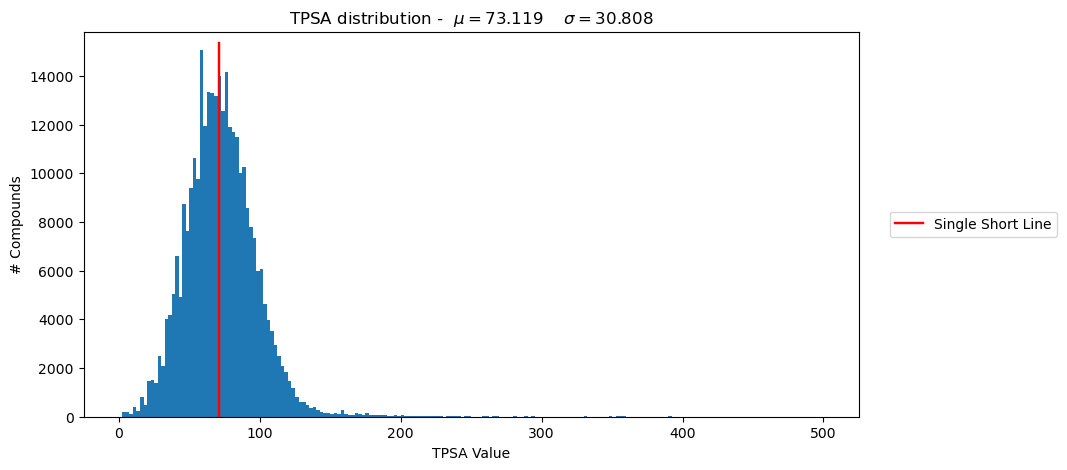

In [259]:
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 200
# fig, ax = plt.subplots()
fig = plt.figure(figsize=(10,5))
sigma = df_train.Metadata_TPSA.std()
mu = df_train.Metadata_TPSA.mean()
med = df_train.Metadata_TPSA.median()
# the histogram of the data
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(df_train.Metadata_TPSA, num_bins, density=False, range=[0, 500],)
# p1 = [(med, 710), (6.0, 605)]
# _ = plt.vlines(x=med, ymin=10, ymax=17000, colors='red', linestyles='-', lw=1.75, label='Single Short Line')
_ = plt.axvline(x=med, ymin=0, ymax=.97, color='red', linestyle='-', lw=1.75, label='Single Short Line')
_ = plt.xlabel('TPSA Value');
_ = plt.ylabel('# Compounds');
_ = plt.title(fr'TPSA distribution -  $\mu={mu:.3f}$    $\sigma={sigma:.3f}$')
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
# axs[1].hist(dist2, bins=n_bins)
plt.show()

# Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

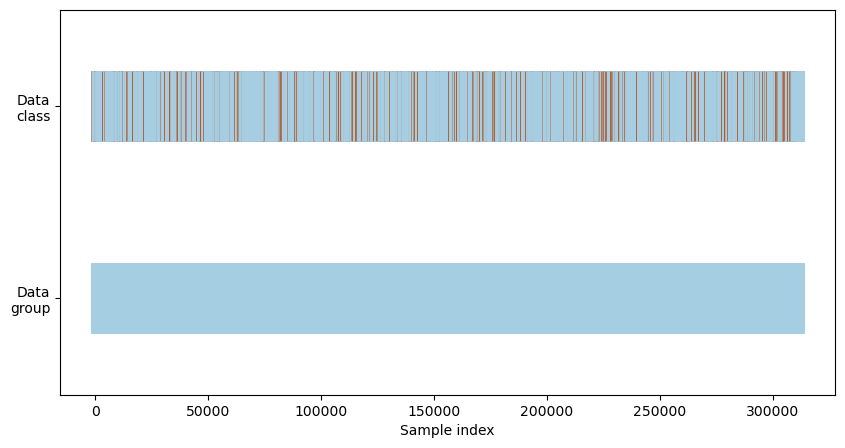

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

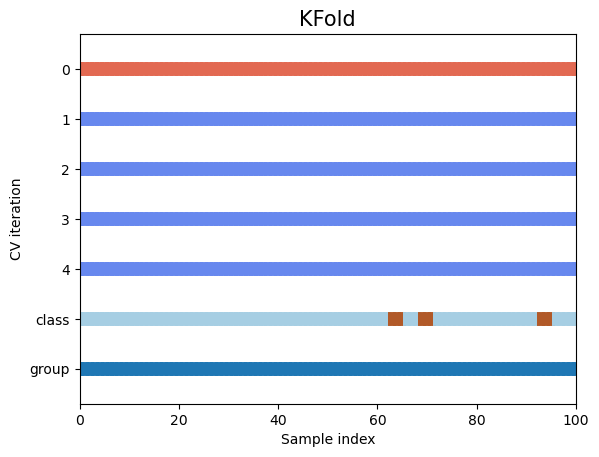

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

# Input 

## Read Embedded Features CSV file

In [11]:
BASE_TRAIN_INPUT = os.path.join(OUTPUT_PATH, INPUT_FILE.format(runmode = BASE_runmode ,datatype='train'))
BASE_TEST_INPUT  = os.path.join(OUTPUT_PATH, INPUT_FILE.format(runmode = BASE_runmode ,datatype='test'))
SNNL_TRAIN_INPUT = os.path.join(OUTPUT_PATH, INPUT_FILE.format(runmode = SNNL_runmode ,datatype='train'))
SNNL_TEST_INPUT  = os.path.join(OUTPUT_PATH, INPUT_FILE.format(runmode = SNNL_runmode ,datatype='test'))
BASE_TRAIN_INPUT
BASE_TEST_INPUT 
SNNL_TRAIN_INPUT
SNNL_TEST_INPUT 

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240718_1956_BEST_train.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_BASELINE_20240718_1956_BEST_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_train.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3sample_profiles_embedding_161_HashOrder_SNNL_20240718_1956_BEST_test.csv'

In [12]:
df_test = pd.read_csv(SNNL_TEST_INPUT )
df_train = pd.read_csv(SNNL_TRAIN_INPUT)

# df_train = pd.read_csv(BASE_TRAIN_INPUT)
# df_test = pd.read_csv(BASE_TEST_INPUT )
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [13]:
df_test.info()
df_test.shape
df_test.columns
df_test.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34542 entries, 0 to 34541
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 42.4+ MB


(34542, 161)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Feature_140', 'Feature_141', 'Feature_142', 'Feature_143', 'Feature_144', 'Feature_145', 'Feature_146', 'Feature_147',
       'Feature_148', 'Feature_149'],
      dtype='object', length=161)

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001
0,source_11,Batch2,EC000046,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.613709,0.704578
1,source_11,Batch2,EC000063,K04,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.396030,1.886775
2,source_9,20211013-Run14,GR00003281,J15,JCP2022_009278,7406361908543180200,8,62.78,4.139637,1.797821,0.0,0.967456,-0.243835
3,source_5,JUMPCPE-20210908-Run28_20210909_072022,AETJUM107,J10,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,-0.355203,0.057036
4,source_11,Batch3,EC000139,G04,JCP2022_045457,7406621140030190348,12,33.20,3.502550,1.521138,0.0,1.246175,0.795314


In [14]:
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [15]:
test_y = df_test.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
test_y.sum()
test_y.shape, type(test_y), test_y.dtype
test_X = df_test.iloc[:,11:].to_numpy()
test_X.shape,type(test_X), test_X.dtype

4164

((34542,), numpy.ndarray, dtype('uint8'))

((34542, 150), numpy.ndarray, dtype('float64'))

In [19]:
df_train.shape
df_train.info()
df_train.iloc[:5,:16]

(312000, 161)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312000 entries, 0 to 311999
Columns: 161 entries, Metadata_Source to Feature_149
dtypes: float64(154), int64(2), object(5)
memory usage: 383.2+ MB


,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_TPSA,Metadata_lnTPSA,Metadata_log10TPSA,Metadata_Permiation,Feature_000,Feature_001,Feature_002,Feature_003,Feature_004
0,source_1,Batch5_20221030,UL001793,M26,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,-0.584816,1.739848,-0.512839,0.171693,-0.277947
1,source_10,2021_06_22_U2OS_48_hr_run8,Dest210622-143628,M04,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,0.072229,4.545980,-0.728832,-6.005501,0.926439
2,source_3,CP_31_all_Phenix1,B040603b,G13,JCP2022_006020,-9223347314827979542,10,71.18,4.265212,1.852358,0.0,1.418385,4.461677,2.481470,-0.635005,-2.307799
3,source_6,p211004CPU2OS48hw384exp031JUMP,110000295562,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,-2.747379,0.744657,2.082911,1.504725,1.156345
4,source_3,CP_32_all_Phenix1,B40003aW,M08,JCP2022_058905,-9223229703754907651,13,58.65,4.071588,1.768268,0.0,0.559964,1.732896,0.296971,-1.477167,1.171373


In [20]:
312000+34542

346542

In [21]:
train_y = df_train.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
train_y.sum()
train_y.shape, type(train_y), train_y.dtype

train_X = df_train.iloc[:,11:].to_numpy()
train_X.shape,type(train_X) ,train_X.dtype

37164

((312000,), numpy.ndarray, dtype('uint8'))

((312000, 150), numpy.ndarray, dtype('float64'))

## Standardize inputs

In [22]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [23]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [24]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [25]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [26]:
label_counts([("Training", train_y), ("Test", test_y)])

 Training
 ---------
 Total samples: 312000  - compounds: 104000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 -----
 Total samples: 34542  - compounds: 11514
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



# TQDM Examples

In [322]:
#-----------------------------------------
# TRANGE example
#-----------------------------------------   
# with trange(+1, ns.trn_iters_warmup+1 , initial = 0 , total = ns.trn_iters_warmup, position=0, file=sys.stdout,
#             leave= False, disable = disable_tqdm, desc=f" Warmup Epoch {ns.current_epoch}/{ns.stop_epoch_warmup}") as t_warmup :
#     for _ in t_warmup:
#         ns.current_iter += 1            

#         batch = next(dldrs.warmup_trn_loader)            
#         environ.set_inputs(batch, input_size)

#         environ.optimize(is_policy=False, 
#                          num_train_layers=ns.num_train_layers,
#                          flag='update_weights', 
#                          verbose = verbose)
    
#         t_warmup.set_postfix({'curr_iter':ns.current_iter, 
#                             'Loss': f"{environ.losses['total']['total'].item():.4f}"})

#-----------------------------------------
# TQDM example
#-----------------------------------------   
# current_epoch = 1
# total_epochs = 20
# current_iter = 0 
# train_minibatches = len(data_loader['train']) // minibatch_size
# val_minibatches = len(data_loader['val']) // minibatch_size

# # with batch_count, (batch_features, batch_labels, _, _, _, _) in tqdm(enumerate(data_loader['train']), initial=0, total = 400, position=0, file=sys.stdout,
#             # leave= False, desc=f" Epoch {current_epoch}/{total_epochs}") as t_warmup :
# t_warmup =  tqdm(enumerate(data_loader['train']), initial=0, total = train_minibatches, position=0, file=sys.stdout,
#             leave= False, desc=f" Epoch {current_epoch}/{total_epochs}") 
# for batch_count, (batch_features, batch_labels, _, _, _, _) in t_warmup:
#     # batch_count, (batch_features, batch_labels, _, _, _, _) = pp
#     loss = random.random()
#     t_warmup.set_postfix({'curr_iter':batch_count, 'Loss': f"{loss:.4f}"})